In [24]:
import os #module that creates, opens, and closes files.
import litellm #
import json
import warnings
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import requests
import networkx as nx 
from tqdm import tqdm
import time 

# Load environment variables
load_dotenv()

# Suppress specific Pydantic warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

custom_api_base = "https://litellmproxy.osu-ai.org" #Class 9 Section 1, key we use for API 
astro1221_key = os.getenv("ASTRO1221_API_KEY") 


In [21]:
filename = "p_paper_abstract.txt"

with open(filename, 'r') as f:  # 'r' means read mode
  lines = f.readlines()
    
print(f"Read {len(lines)} lines from file") #Necessary?

Read 9 lines from file


In [43]:
conversation_prompt = """ 
CHARACTERS:
-Dr. Daniel Beer: an enthusiastic and inquisitive astrophysicist that studies cosmology, including dark matter
and dark energy, galactic evolution and quasars, and the intergalactic medium (IGM).

-Dr. Davis Milk: a curious and passionate astrophysicist that studies supermassive black holes.

-Dr. Phil Marg: an excited and speculative astrophyscist that studies
cosmology, specifically galactic evolution and active galactic nuclei (AGN).

DISCUSSION:
Have the characters have a debate about the paper THE ORIGIN OF DUST IN EARLY-TYPE GALAXIES 
AND IMPLICATIONS FOR ACCRETION ONTO SUPERMASSIVE BLACK HOLES 
Paul Martini 1,4,  Daniel Dicken 2, and Thaisa Storchi-Bergmann. 

CONVERSATION FLOW: 
Have the characters talk in random order amongst each other as if they are humans having an ordinary debate. 
They do not have to talk in the order in which the characters are listed 
- For example, the order can be: "Dr. Phil Marg" to "Dr. Davis Milk" to "Dr. Phil Marg" to "Dr. Daniel Milk". 
Make the conversation natural. 
."""

#Class 9: Section 4 



In [44]:
def prompt_llm(messages, model="openai/GPT-4.1-mini", temperature=0.5, max_tokens=1000, tools=None, verbose=True): #Class 9 Section 1 
    """
    Send a prompt or conversation to an LLM using LiteLLM and return the response.
    """
    if isinstance(messages, str):
        messages = [{"role": "user", "content": conversation_prompt}] #changed "content": messages to --> "content":conversation_prompt (12/14)
    if not (isinstance(temperature, (int, float)) and 0 <= temperature <= 2): #kept all of this the same (12/14)
        raise ValueError("temperature must be a float between 0 and 2 (inclusive).")
    if not (isinstance(max_tokens, int) and max_tokens > 0):
        raise ValueError("max_tokens must be a positive integer.")
    #creates a prompt function prompt_llm(prompt, shows GPT version, med creativity, response length, tools, verbose = true provides detailed info)

    try: 
        print("Contacting LLM via University Server...")
        conversation_response = litellm.completion(
            model=model,
            messages=messages,
            tools=tools,
            api_base=custom_api_base,
            api_key=astro1221_key,
            temperature=temperature,
            max_tokens=max_tokens, 
        )
        conversation_answer = conversation_response['choices'][0]['message']['content'] #choices? what does this do, ask in class (12/12), added "conversation'" in front of response and answer variables
        if verbose: 
            print(f"\nSUCCESS! Here is the discussion from {model}:\n")
            print(conversation_answer + "\n")
            print(f"{conversation_answer['name']}: {conversation_answer['reply']}")
            conversation_history += f"{conversation_answer['name']}: {conversation_answer['reply']}\n"
    except Exception as e:
        print(f"\nERROR: Could not connect. Details:\n{e}")    
        conversation_response = None
    return conversation_response 

 

In [48]:
conversation_history = [{"role": "user", "content": conversation_prompt}] 
def conversation_with_history(user_input):
    conversation_history.append({"role": "user", "content": user_input})
    response = prompt_llm(conversation_history) 
    if response is None:
        return None
    ai_answer = response.choices[0].message.content

    # 5. CRITICAL: Add the AI's own answer to memory so it remembers what it said
    conversation_history.append({"role": "assistant", "content": ai_answer})

    return ai_answer
#Class 9 Section 5

In [50]:
prompt_llm(conversation_prompt)
print('=' * 60) #Spacing for organization

conversation_summary_prompt = "Make an organized list to show which characters interacted with each other and how many times they did."
print(f"\nAsking about question original conversation: {conversation_summary_prompt}")
print(conversation_with_history(conversation_summary_prompt)) # AI/LLM remembers what three characters talked about. 

#Class 9 Section 5

Contacting LLM via University Server...

SUCCESS! Here is the discussion from openai/GPT-4.1-mini:

Dr. Davis Milk: You know, I found the Martini et al. paper quite intriguing, especially their argument that the dust in early-type galaxies primarily originates from external accretion rather than internal stellar processes. It really challenges some of the assumptions we've had about the feeding mechanisms for supermassive black holes in these galaxies.

Dr. Phil Marg: Absolutely, Davis! I was particularly excited by their implications for AGN activity. If dust is mainly brought in through mergers or interactions, it could explain the episodic nature of AGN fueling. It’s almost like these early-type galaxies are dormant most of the time until a fresh injection of dusty material wakes up their central engines.

Dr. Daniel Beer: That’s a good point, Phil. But I wonder about the efficiency of this external accretion in actually delivering gas to the central black hole. The paper mentions t

In [105]:
import csv

response_data = [
      {'Link': 'Dr. Daniel Beer - Dr. Davis Milk', 'Interaction Count': 1},
      {'Link': 'Dr. Davis Milk - Dr. Phil Marg',   'Interaction Count': 2},
      {'Link': 'Dr. Phil Marg - Dr. Daniel Beer',  'Interaction Count': 2}
]
with open('response_data.csv', 'w', newline='') as file:
    fieldnames = ['Link', 'Interaction Count']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(response_data)
    
print("Created response_data.csv") 
# Write data rows
with open('response_data.csv', mode='r') as file:
    reader = csv.DictReader(file)
    print(f"{'Link'}                        |  {'Interaction Count'}")
    print("=" * 50)
    
    for row in reader:
        link = row['Link']
        interaction_count = float(row['Interaction Count'])
        
        print(f"{link} |        {interaction_count}")

#Class 4 Section 6
  
#Is there a way to make a count for how many times each character says each others names, and then make a network graph to track that 

Created response_data.csv
Link                        |  Interaction Count
Dr. Daniel Beer - Dr. Davis Milk |        1.0
Dr. Davis Milk - Dr. Phil Marg |        2.0
Dr. Phil Marg - Dr. Daniel Beer |        2.0


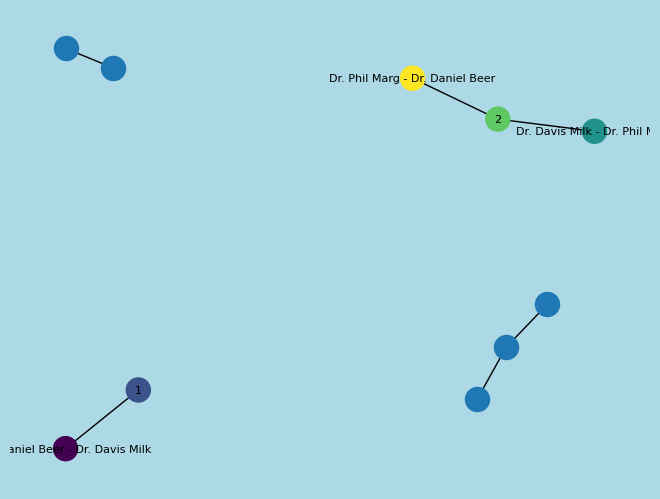

In [114]:
import pandas as pd

df = pd.read_csv("response_data.csv")
df
G= nx.from_pandas_edgelist(df, "Link", "Interaction Count")
val = []
for i in range(len(G.nodes)):
    val.append(i)
nx.set_node_attributes(G, val, 'val')
fig = plt.figure()
nx.draw(G)
nx.draw(G, with_labels=True, font_size=8, node_color=val) 
fig.set_facecolor('lightblue')
plt.show()